# MCMC with Stellar Atmospheres

Started 11 October 2019. This notebook is meant to (finally) incorporate stellar atmospheres into the MCMC fit. Resampling is done in the actual MCMC to not have too many points. Let's see how this works.

### Imports

In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
from scipy import integrate
from astropy.convolution import convolve, convolve_fft
import matplotlib.pyplot as plt
from fu_ori_functions_oct11 import *
from fu_ori_classes_oct11 import *
import matplotlib.gridspec as gridspec

import emcee
import corner
import time
%matplotlib inline 

In [2]:
G = 6.67259e-8
SIG_SB = 5.67051e-5
M_SUN = 1.99e33
R_SUN = 6.96e10
L_SUN = 3.839e33
h_PLANCK = 6.6260755e-27
c_LIGHT = 2.99792458e10
k_BOLTZ = 1.380658e-16

In [3]:
ATM_TABLE = dict()
ATMOS_FACTOR = 100

In [4]:
def direcToArray(directory):
    for temp in range(2000, 10000+ATMOS_FACTOR, ATMOS_FACTOR):
        for grav in [1.5, 4.0]:
            try:
                atmos_file = directory + 'pr.lte' + str(int(temp/ATMOS_FACTOR)) \
                        + '-' + str(grav) + '-0.0.spec'
                txt = open(atmos_file)
                fulltxt = txt.readlines()
                # Cleaning lines
                newtxt = []
                for i in range(len(fulltxt)):
                    line = fulltxt[i][:-1]
                    line = line.split()
                    newtxt.append(line)
        
                # Casting as floats
                newtxt = np.array(newtxt).astype(np.float64)
                
                # Choosing which model to use
                wav, lum = newtxt[:,0], newtxt[:,1]
                ATM_TABLE[(temp, grav)] = np.array([wav, lum])
            except:
                print('No atmosphere found for temp = ' + str(temp) + \
                      ' grav = ' + str(grav))

In [5]:
direcToArray('C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/')

No atmosphere found for temp = 7100 grav = 1.5
No atmosphere found for temp = 7100 grav = 4.0
No atmosphere found for temp = 7300 grav = 1.5
No atmosphere found for temp = 7300 grav = 4.0
No atmosphere found for temp = 7500 grav = 1.5
No atmosphere found for temp = 7500 grav = 4.0
No atmosphere found for temp = 7700 grav = 1.5
No atmosphere found for temp = 7700 grav = 4.0
No atmosphere found for temp = 7900 grav = 1.5
No atmosphere found for temp = 7900 grav = 4.0
No atmosphere found for temp = 8100 grav = 1.5
No atmosphere found for temp = 8100 grav = 4.0
No atmosphere found for temp = 8300 grav = 1.5
No atmosphere found for temp = 8300 grav = 4.0
No atmosphere found for temp = 8500 grav = 1.5
No atmosphere found for temp = 8500 grav = 4.0
No atmosphere found for temp = 8700 grav = 1.5
No atmosphere found for temp = 8700 grav = 4.0
No atmosphere found for temp = 8900 grav = 1.5
No atmosphere found for temp = 8900 grav = 4.0
No atmosphere found for temp = 9100 grav = 1.5
No atmosphere

In [115]:
class FUOriEnvironment:
    
    # Initializer / Instance Attributes
    def __init__(self, wave_lower_SED, wave_upper_SED):
        
        self.wave_lower_SED = wave_lower_SED
        self.wave_upper_SED = wave_upper_SED
        
        # Storing classes
        self.fuori = 0
        
#         print('Created environment.')
        
    # instance methods
    
    # Creating FU Ori object as accretion disk
    def createFUOri(self, r_star, r_outer, m_star, m_dot, inc, dist, grav, direc, a_v, atm_table):
        fuori = FUOri(r_star, r_star, r_outer, m_star, m_dot, np.radians(inc), a_v, atm_table)
        fuori.setAnnuliValues(10000, 2000, 200, 2*R_STAR)
        fuori.createAnnuliFromDirec(grav, direc, 'stellar atmospheres')
        fuori.prepareAnnuli(self.wave_lower_SED,self.wave_upper_SED, \
                            binning=10, broaden=False, interp_type='linear')
        fuori.createModelSpectrum('stellar atmospheres', broaden=False)
        self.fuori = fuori
    
    
    # For viewing model spectrum
    def viewModelSpectrum(self, wave_lower, wave_upper, redden):
            return self.fuori.viewModelSpectrum(wave_lower, wave_upper, False, redden)
    def getModSpecPoint(self, wave, redden):
        return np.mean(self.viewModelSpectrum(wave-10, wave+10, redden)[1])

### Making an instance of the class

In [116]:
M_STAR = 0.69*M_SUN
R_STAR= 0.59*R_SUN
R_OUTER = 15*R_SUN
M_DOT = (10**-1.01) * 1e-6 * M_SUN / 3.154e7

A_V = 3.

INC = 15.

DIST = 1.27e3*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [117]:
%time gaia17bpi_env = FUOriEnvironment(3.0e3, 28.5e3)
%time gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, direc = DIREC, atm_table=ATM_TABLE)
%time modSpec = gaia17bpi_env.viewModelSpectrum(3.5e3, 28e3, True)
wav, lum = modSpec

Wall time: 1.99 ms
Wall time: 82.8 ms
Wall time: 20.9 ms


In [118]:
WAV_DAT = np.array([-0.3763388 , -0.33833323, -0.30032766, -0.26232209, -0.22431652,
       -0.18631095, -0.14830538, -0.11029981, -0.07229424, -0.03428867,
        0.0037169 ,  0.04172247,  0.07972804,  0.11773361,  0.15573918,
        0.19374475,  0.23175032,  0.26975589,  0.30776146,  0.34576703])

In [119]:
FLUX_DAT = np.array([-12.69867368, -12.37656613, -12.0829846 , -11.83460523,
       -11.63780456, -11.5029503 , -11.4107528 , -11.26197095,
       -11.1836271 , -11.0152355 , -10.9114616 , -10.83732447,
       -10.7837376 , -10.72835477, -10.78237973, -10.72343372,
       -10.67219998, -10.77972299, -10.79968741, -10.74845085])

In [120]:
FLUX_DAT_ERR = -0.01*FLUX_DAT

### Plotting data with model

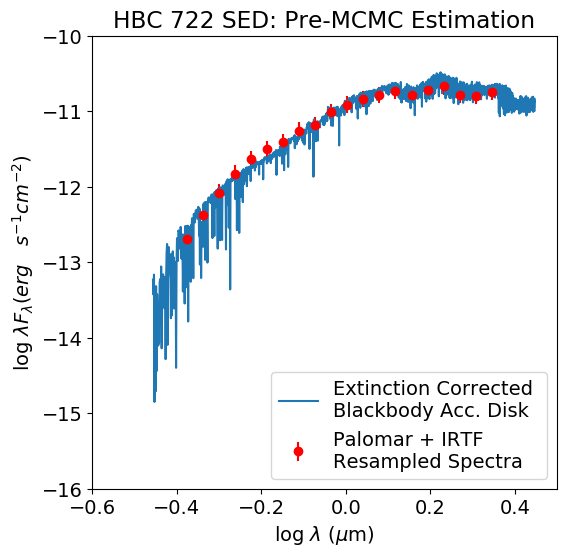

In [121]:
fig=plt.figure(figsize=(6, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.plot(np.log10(wav*1e-4), np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2)), \
         '-', label='Extinction Corrected \nBlackbody Acc. Disk')

plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
             linestyle='', color='r',label='Palomar + IRTF \nResampled Spectra')

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('HBC 722 SED: Pre-MCMC Estimation')
plt.ylim(-16, -10)
plt.xlim(-0.6, 0.5)
plt.legend()
# plt.savefig("sed_gaia17bpi_75.png", dpi=200, bbox_inches='tight')
plt.show()

## MCMC Routine

In [122]:
def lnlike(theta, x, y, yerr):
    m_star, r_star, m_dot= theta
    r_star = r_star*R_SUN
    
    m_dot = 10**m_dot
    m_star = 10**m_star
    m_star = m_star*M_SUN
    
    m_dot = m_dot* 1e-6 * M_SUN / 3.154e7
    try:
    
        gaia17bpi_env = FUOriEnvironment(2.5e3, 3e4)
        gaia17bpi_env.createFUOri(r_star = r_star, r_outer = R_OUTER, m_star = m_star,\
                              m_dot = m_dot, inc = INC, a_v = A_V, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE)
    
    # Accounts for any random case where the model may not be generated properly given a certain combination
    # of parameters. This has only happened once, but it's presumably when the maximum temperature is too low.
    except:
        print('Weird array error')
        gaia17bpi_env = FUOriEnvironment(2.5e3, 3e4)
        gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                              m_dot = m_dot, inc = INC, a_v = A_V, dist = DIST, grav = 1.5, \
                                  direc = DIREC, atm_table=ATM_TABLE)
        
    
    # Converting units to properly compare model to data
    x = (10**x)*1e4
    modSpec = np.zeros(len(x))
    for i in range(len(x)):
        modSpec[i] = gaia17bpi_env.getModSpecPoint(x[i], True)
    flux = np.cos(np.radians(INC))*modSpec/(2*np.pi*DIST**2)

    model = np.log10(x*flux*1e-8)
    inv_sig = 1/yerr
    return np.sum(np.log((1/np.sqrt(2*np.pi))*inv_sig) - 0.5*((y - model)*inv_sig)**2)

In [123]:
M_STAR_LOW = -1.0
M_STAR_HIGH = 0.8
R_STAR_LOW = 0.3
R_STAR_HIGH = 4.0

M_DOT_LOW = -1.5
M_DOT_HIGH = 3.5

In [124]:
def lnprior(theta):
    m_star, r_star, m_dot= theta
    if M_DOT_LOW  < m_dot < M_DOT_HIGH \
    and M_STAR_LOW < m_star < M_STAR_HIGH\
    and R_STAR_LOW < r_star < R_STAR_HIGH:
        return 0.0
    return -np.inf

In [125]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return (lp + lnlike(theta, x, y, yerr))

In [145]:
ndim, nwalkers = 3, 16
m_star_start = -0.16
r_star_start = 0.59
m_dot_start = -1.0
start = np.array((m_star_start, r_star_start, m_dot_start))
pos = [start + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [146]:
x = WAV_DAT
y_meas = FLUX_DAT
y_err = FLUX_DAT_ERR

In [147]:
lnprob((m_star_start, r_star_start, m_dot_start), x,y_meas,y_err)

18.49564313990986

In [148]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_meas, y_err))
%time sampler.run_mcmc(pos, 1600, progress=True)

100%|████████████████████████████████████████████████████████████████████████████| 1600/1600 [3:42:52<00:00,  3.73s/it]


Wall time: 3h 42min 57s


State([[-0.51936514  0.55360083 -0.65942872]
 [-0.56963811  0.58515035 -0.59512585]
 [ 0.26363673  0.59730157 -1.41696289]
 [-0.1595606   0.49942465 -1.08968874]
 [-0.66329214  0.45746155 -0.66268557]
 [-0.43470789  0.51448259 -0.8079071 ]
 [-0.84939173  0.54628855 -0.40641357]
 [-0.50310196  0.49891592 -0.77435003]
 [-0.84158244  0.53133602 -0.38026222]
 [-0.91005151  0.52264425 -0.33879776]
 [-0.9787763   0.5511013  -0.22102132]
 [ 0.05574667  0.44367389 -1.35827276]
 [-0.99064778  0.4805696  -0.32029064]
 [-0.88114939  0.4362788  -0.45713706]
 [-0.74034895  0.55104393 -0.44777506]
 [-0.10426502  0.50396826 -1.14062737]], log_prob=[19.17202261 18.63084151 18.27571891 19.88355962 19.1901036  19.98048864
 16.59838996 19.83232562 19.92709005 19.74648318 19.66885623 18.05800479
 19.18994435 18.55465942 19.45512233 19.877479  ], blobs=None, random_state=('MT19937', array([ 244651014,  871739516, 3559776367,  569697888, 2023114063,
       1341768236,  530816818, 1280403778, 2572692349, 269

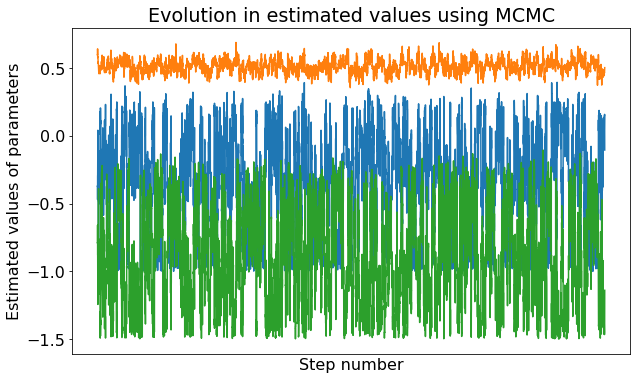

In [151]:
samples = sampler.chain[:, 600:, :].reshape((-1, ndim))
fig = plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 16})

plt.plot(samples)
plt.xlabel('Step number')
plt.ylabel('Estimated values of parameters')
plt.title('Evolution in estimated values using MCMC')
plt.xticks([])
plt.show()

Quantiles:
[(0.16, -0.7935350945617364), (0.5, -0.36629763768117596), (0.84, 0.061534676784743114)]
Quantiles:
[(0.16, 0.4710498982494793), (0.5, 0.5142953729703896), (0.84, 0.5572652017016324)]
Quantiles:
[(0.16, -1.310360887354881), (0.5, -0.8880290721262172), (0.84, -0.4502202510682483)]


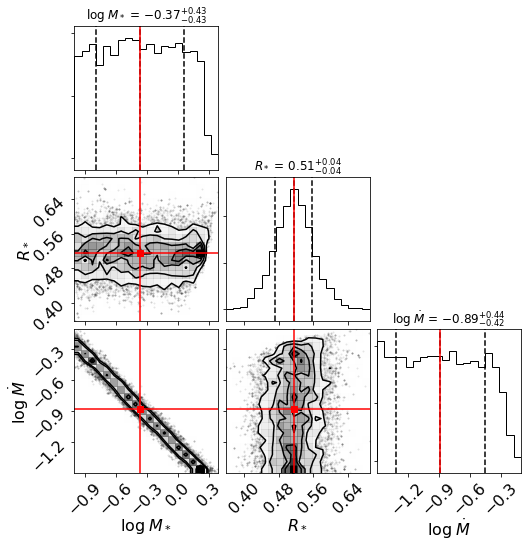

In [153]:
median_calcuated = np.median(samples, axis=0)

fig = corner.corner(samples, labels=[r'$\log\; M_*$', r'$R_*$',r'$\log\;\dot{M}$'], verbose=True,
                       quantiles=(0.16, 0.5,0.84), plot_contours=True, scale_hist=True,
                       show_titles=True, title_kwargs={"fontsize": 12})

axes = np.array(fig.axes).reshape((ndim, ndim))

for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(median_calcuated[i], color="r")
    
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(median_calcuated[xi], color="r")
        ax.axhline(median_calcuated[yi], color="r")
        ax.plot(median_calcuated[xi], median_calcuated[yi], "sr")

fig.show()
# fig.savefig("gaia17bpi_1028_15.png", dpi=140)

## Plotting after fit

In [60]:
M_STAR = (10**-0.32)*M_SUN
R_STAR= 0.52*R_SUN
R_OUTER = 15 * R_SUN
M_DOT = (10**-0.92) * 1e-6 * M_SUN / 3.154e7

A_V = 3.

INC = 15.

DIST = 1.27e3*3.08567758128e18
DIREC = 'C:/Users/tonyc/OneDrive/Documents/2019 Summer/Stellar Atmospheres/'

In [61]:
gaia17bpi_env = FUOriEnvironment(1.5e3, 30.5e3)
gaia17bpi_env.createFUOri(r_star = R_STAR, r_outer = R_OUTER, m_star = M_STAR,\
                          m_dot = M_DOT, inc = INC, a_v = A_V,dist = DIST, grav = 1.5, direc = DIREC, atm_table=ATM_TABLE)
%time modSpec = gaia17bpi_env.viewModelSpectrum(2.9e3, 28e3, True)
wav, lum = modSpec

Wall time: 20.9 ms


In [62]:
gaia17bpi_env.fuori.annuli[0].temp

6000.0

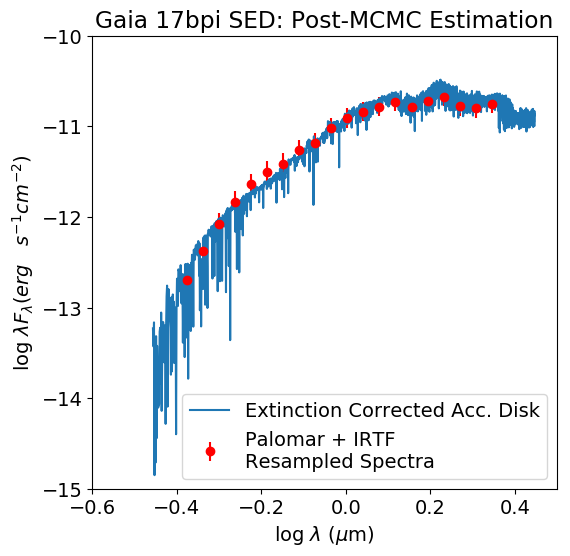

In [155]:
fig=plt.figure(figsize=(6, 6), dpi= 100)
plt.rcParams.update({'font.size': 14})
plt.plot(np.log10(wav*1e-4), np.log10(lum*wav*1e-8*np.cos(np.radians(INC))/(2*np.pi*DIST**2)), \
         '-', label='Extinction Corrected Acc. Disk')

plt.errorbar(WAV_DAT, FLUX_DAT, yerr=FLUX_DAT_ERR, marker='o', \
             linestyle='', color='r',label='Palomar + IRTF \nResampled Spectra')

plt.xlabel(r'log $\lambda$ ($\mu$m)')
plt.ylabel(r'log $\lambda F_\lambda (erg\quad s^{-1} cm^{-2})$')
plt.title('Gaia 17bpi SED: Post-MCMC Estimation')
plt.ylim(-15, -10)
plt.xlim(-0.6, 0.5)
plt.legend()
# plt.savefig("sed_gaia17bpi_75.png", dpi=200, bbox_inches='tight')
plt.show()